In [ ]:
!pip install hmmlearn biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 23.9 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CoV-AbDab_080224.csv to CoV-AbDab_080224.csv


In [ ]:
import pandas as pd
df = pd.read_csv("/content/CoV-AbDab_080224.csv")

In [ ]:
#create training labels
def label_neutralization(row):
    neut = str(row["Neutralising Vs"]).strip()
    non = str(row["Not Neutralising Vs"]).strip()

    if neut not in ["", "nan", "NaN"] and neut != "None":
        return 1
    if non not in ["", "nan", "NaN"] and non != "None":
        return 0
    return None   # unknown

df["label"] = df.apply(label_neutralization, axis=1)
df = df.dropna(subset=["label"])
df["label"] = df["label"].astype(int)

In [ ]:
#extracting the CDRH3 sequences
df = df[df["CDRH3"].notna()] #remove rows with missing CDRH3
neutralizing_seqs = df[df["label"] == 1]["CDRH3"].tolist() #looks at label =1 (neutralizing), remove rows with CDRH3, makes it into list
non_neut_seqs = df[df["label"] == 0]["CDRH3"].tolist() #looks at label =0 (non- neutralizing), remove rows CDRH3, makes it into list

In [ ]:
#converting amino acid sequences to integers
import numpy as np

AA = "ACDEFGHIKLMNPQRSTVWY"
aa_to_idx = {aa:i for i,aa in enumerate(AA)}

def one_hot(seq):
    arr = np.zeros((len(seq), 20), dtype=int)
    for i, aa in enumerate(seq):
        if aa in aa_to_idx:
            arr[i, aa_to_idx[aa]] = 1
    return arr


In [ ]:
neut_encoded = [one_hot(s) for s in neutralizing_seqs]
non_neut_encoded = [one_hot(s) for s in non_neut_seqs]

In [ ]:
#default trained for 10 iterations
from hmmlearn.hmm import MultinomialHMM

np.random.seed(42)  # Added this for reproducibility

def train_hmm(seqs, n_states=6):
    model = MultinomialHMM(n_components=n_states, random_state=42) #take out random state if results are worse
    model.n_features = 20  # 20 amino acids

    lengths = [len(s) for s in seqs]
    X = np.vstack(seqs)  # shape = (total_len, 20)

    model.fit(X, lengths)
    return model


In [ ]:
HMM_neut = train_hmm(neut_encoded, n_states=6)
HMM_non = train_hmm(non_neut_encoded, n_states=6)

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


In [ ]:
import pandas as pd
import numpy as np

# List of amino acids
AA = "ACDEFGHIKLMNPQRSTVWY"
aa_to_idx = {aa:i for i,aa in enumerate(AA)}

# Function to create labeled DataFrame for emission matrix
def create_emission_df(emission_matrix, amino_acids=AA):
    n_states = emission_matrix.shape[0]
    df = pd.DataFrame(emission_matrix, columns=list(amino_acids))
    df.index = [f"State_{i+1}" for i in range(n_states)]
    return df

# Create labeled DataFrames
em_neut_df = create_emission_df(HMM_neut.emissionprob_)
em_non_df = create_emission_df(HMM_non.emissionprob_)

# Display the DataFrames
print("Neutralizing Antibodies Emission Probability Matrix:")
display(em_neut_df.round(4))

print("\nNon-Neutralizing Antibodies Emission Probability Matrix:")
display(em_non_df.round(4))


Neutralizing Antibodies Emission Probability Matrix:


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
State_1,0.0592,0.0095,0.3235,0.0542,0.0050,0.1794,0.0167,0.0202,0.0052,0.0509,0.0036,0.0229,0.0327,0.0185,0.0218,0.0457,0.0398,0.0500,0.0237,0.0175
State_2,0.8830,0.0006,0.0001,0.0000,0.0004,0.0062,0.0019,0.0007,0.0000,0.0030,0.0003,0.0086,0.0000,0.0006,0.0000,0.0079,0.0356,0.0486,0.0006,0.0018
State_3,0.0034,0.0227,0.0043,0.0109,0.2685,0.1068,0.0159,0.0059,0.0061,0.0272,0.0469,0.0418,0.0456,0.0080,0.0251,0.1385,0.0082,0.0089,0.0019,0.2036
State_4,0.0474,0.0004,0.0224,0.0312,0.0499,0.0721,0.0102,0.1026,0.0056,0.1405,0.0637,0.0127,0.0559,0.0190,0.0361,0.0360,0.0585,0.1764,0.0144,0.0450
State_5,0.0786,0.0018,0.0027,0.0062,0.0118,0.0186,0.0188,0.0082,0.1268,0.0076,0.0037,0.0046,0.0021,0.0036,0.5840,0.0359,0.0671,0.0170,0.0002,0.0006
State_6,0.0358,0.0272,0.0531,0.0099,0.0134,0.1086,0.0294,0.0071,0.0055,0.0044,0.0000,0.0193,0.0565,0.0084,0.0357,0.1241,0.0418,0.0108,0.0598,0.3490



Non-Neutralizing Antibodies Emission Probability Matrix:


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
State_1,0.0695,0.0074,0.3090,0.0447,0.0085,0.1716,0.0174,0.0248,0.0044,0.0521,0.0043,0.0213,0.0308,0.0200,0.0264,0.0403,0.0462,0.0615,0.0246,0.0154
State_2,0.8967,0.0000,0.0000,0.0000,0.0004,0.0037,0.0004,0.0026,0.0000,0.0000,0.0000,0.0041,0.0000,0.0003,0.0006,0.0062,0.0346,0.0492,0.0004,0.0008
State_3,0.0030,0.0164,0.0026,0.0040,0.2643,0.0906,0.0134,0.0051,0.0057,0.0258,0.0778,0.0555,0.0325,0.0059,0.0232,0.1386,0.0035,0.0063,0.0006,0.2252
State_4,0.0551,0.0007,0.0173,0.0307,0.0582,0.0742,0.0071,0.0932,0.0051,0.1270,0.0492,0.0087,0.0790,0.0217,0.0398,0.0431,0.0578,0.1853,0.0220,0.0250
State_5,0.0321,0.0015,0.0017,0.0150,0.0070,0.0327,0.0221,0.0137,0.1525,0.0069,0.0059,0.0031,0.0035,0.0066,0.5902,0.0359,0.0606,0.0087,0.0005,0.0000
State_6,0.0269,0.0305,0.0491,0.0030,0.0071,0.1185,0.0291,0.0033,0.0055,0.0018,0.0000,0.0226,0.0424,0.0046,0.0199,0.1329,0.0323,0.0057,0.0522,0.4127


**Generating heat maps to visualize difference between neutralizing and non-neuatralizing emission probabilities**

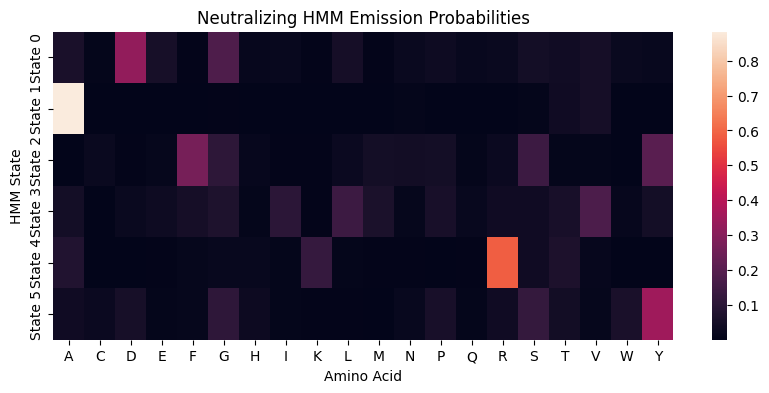

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

aa_order = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

# Determine shared min and max for the color scale
vmin = min(HMM_neut.emissionprob_.min(), HMM_non.emissionprob_.min())
vmax = max(HMM_neut.emissionprob_.max(), HMM_non.emissionprob_.max())

plt.figure(figsize=(10,4))
sns.heatmap(HMM_neut.emissionprob_, xticklabels=aa_order, yticklabels=[f"State {i}" for i in range(6)])
plt.title("Neutralizing HMM Emission Probabilities")
plt.xlabel("Amino Acid")
plt.ylabel("HMM State")
plt.show()


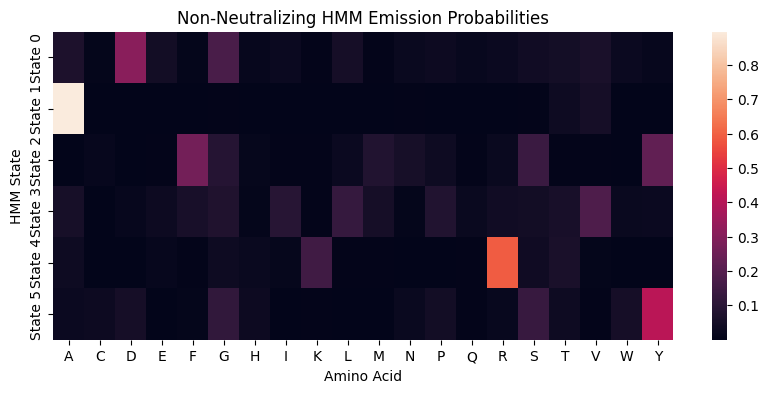

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

aa_order = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

# Determine shared min and max for the color scale
vmin = min(HMM_neut.emissionprob_.min(), HMM_non.emissionprob_.min())
vmax = max(HMM_neut.emissionprob_.max(), HMM_non.emissionprob_.max())

plt.figure(figsize=(10,4))
sns.heatmap(HMM_non.emissionprob_, xticklabels=aa_order, yticklabels=[f"State {i}" for i in range(6)])
plt.title("Non-Neutralizing HMM Emission Probabilities")
plt.xlabel("Amino Acid")
plt.ylabel("HMM State")
plt.show()


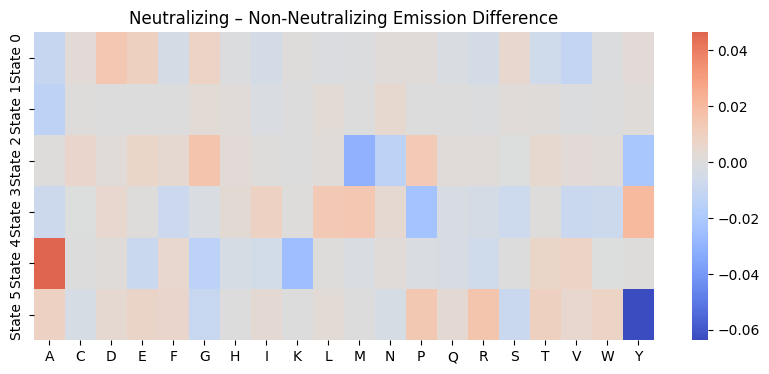

In [ ]:
diff = HMM_neut.emissionprob_ - HMM_non.emissionprob_

plt.figure(figsize=(10,4))
sns.heatmap(diff,
            cmap="coolwarm",
            center=0,
            xticklabels=aa_order,
            yticklabels=[f"State {i}" for i in range(6)])
plt.title("Neutralizing – Non-Neutralizing Emission Difference")
plt.show()
